# Tower A 2D Demo v2

A simplified PINN walkthrough comparing a finite-difference reference to a PINA-based PINN. The PDE residual is scale-free (Δφ) and the interior is intentionally oversampled.

**Imports and runtime configuration**

In [25]:
import os
from dataclasses import dataclass
from typing import Dict, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch._dynamo

from pina import Condition, LabelTensor
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.operator import grad, div, laplacian
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer
from lightning.pytorch.callbacks import EarlyStopping

torch._dynamo.config.disable = True
torch._dynamo.config.suppress_errors = True
os.environ.setdefault("TORCH_COMPILE_DISABLE", "1")

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "image.origin": "lower",
    "axes.grid": False,
})

torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda")
    print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend (Metal).")
else:
    device = torch.device("cpu")
    print("Using CPU.")

def trainer_device_kwargs() -> Dict[str, object]:
    if torch.cuda.is_available():
        return {"accelerator": "cuda", "devices": 1}
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return {"accelerator": "mps", "devices": 1}
    return {"accelerator": "cpu", "devices": 1}

Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)


**Geometry, grids, and finite-difference reference**

Grid spacing: dx=0.0125 mm, dz=0.0125 mm
Electrode spans 4 nodes on z=0 mm
Gauge spans 241 nodes on z=12.0 mm


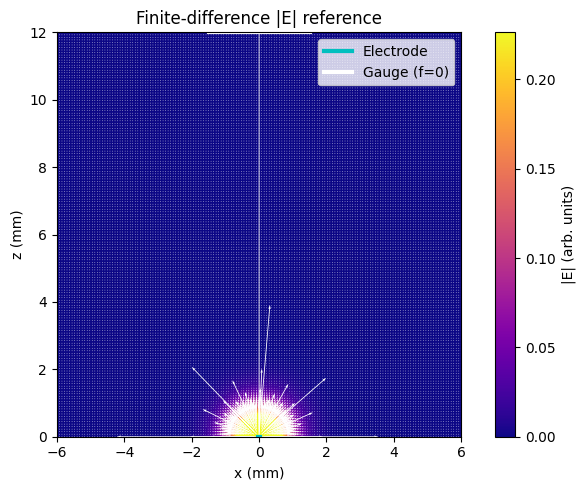

In [26]:
# Domain (mm)
Lx_mm = 12.0
Lz_mm = 12.0
x_min, x_max = -Lx_mm / 2, Lx_mm / 2
z_min, z_max = 0.0, Lz_mm
contact_halfwidth_mm = 0.025
gauge_halfwidth_mm = 1.5

# Grid resolution (961^2 keeps the FD reference smooth)
Nx = 961
Nz = 961
x = np.linspace(x_min, x_max, Nx)
z = np.linspace(z_min, z_max, Nz)
dx = float(x[1] - x[0])
dz = float(z[1] - z[0])
X, Z = np.meshgrid(x, z, indexing="ij")
print(f"Grid spacing: dx={dx:.4f} mm, dz={dz:.4f} mm")

# Boundary index helpers
j_bottom = 0
j_top = Nz - 1


def make_bottom_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    return np.abs(x - center_mm) <= half_width_mm


electrode_mask = make_bottom_mask(0.0, contact_halfwidth_mm)
gauge_mask = np.abs(x) <= gauge_halfwidth_mm
print(f"Electrode spans {electrode_mask.sum()} nodes on z=0 mm")
print(f"Gauge spans {gauge_mask.sum()} nodes on z={z_max} mm")


def solve_laplace_fd(
    electrode_mask: np.ndarray,
    *,
    phi_electrode: float = 1.0,
    phi_gauge: float = 0.0,
    gauge_mask: np.ndarray = gauge_mask,
    max_iters: int = 8_000,
    tol: float = 1e-5,
    verbose: bool = False,
) -> np.ndarray:
    # Jacobi relaxation for Laplace's equation with mixed BCs
    phi = np.zeros((Nx, Nz), dtype=np.float64)
    electrode_idx = electrode_mask.astype(bool)
    gauge_idx = gauge_mask.astype(bool)

    for it in range(max_iters):
        phi_old = phi.copy()
        phi[1:-1, 1:-1] = 0.25 * (
            phi_old[2:, 1:-1] + phi_old[:-2, 1:-1] +
            phi_old[1:-1, 2:] + phi_old[1:-1, :-2]
        )

        phi[~electrode_idx, j_bottom] = phi[~electrode_idx, j_bottom + 1]
        phi[electrode_idx, j_bottom] = phi_electrode

        phi[~gauge_idx, j_top] = phi[~gauge_idx, j_top - 1]
        phi[gauge_idx, j_top] = phi_gauge

        phi[0, :] = phi[1, :]
        phi[-1, :] = phi[-2, :]

        err = float(np.max(np.abs(phi - phi_old)))
        if verbose and it % 500 == 0:
            print(f"iter {it:5d}, max dphi = {err:.3e}")
        if err < tol:
            break

    return phi


def compute_field(phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dphi_dx = np.zeros_like(phi)
    dphi_dz = np.zeros_like(phi)

    dphi_dx[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    dphi_dx[0, :] = (phi[1, :] - phi[0, :]) / dx
    dphi_dx[-1, :] = (phi[-1, :] - phi[-2, :]) / dx

    dphi_dz[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dz)
    dphi_dz[:, 0] = (phi[:, 1] - phi[:, 0]) / dz
    dphi_dz[:, -1] = (phi[:, -1] - phi[:, -2]) / dz

    Ex = -dphi_dx
    Ez = -dphi_dz
    Emag = np.sqrt(Ex**2 + Ez**2)
    return Ex, Ez, Emag


def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    electrode_mask: np.ndarray = electrode_mask,
    gauge_mask: np.ndarray = gauge_mask,
    step: int = 6,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
) -> None:
    Xs = X[::step, ::step]
    Zs = Z[::step, ::step]
    Exs = Ex[::step, ::step]
    Ezs = Ez[::step, ::step]

    vmax = float(vmax) if vmax is not None else float(np.max(Emag) + 1e-12)

    plt.figure(figsize=(7, 5))
    plt.imshow(
        Emag.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect='equal',
        cmap=cmap,
        vmin=0.0,
        vmax=vmax,
    )
    plt.colorbar(label='|E| (arb. units)')

    plt.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        scale=40 * vmax,
        width=0.002,
    )

    plt.plot(x[electrode_mask], np.full(electrode_mask.sum(), z_min), "c", lw=3, label="Electrode")
    plt.plot(x[gauge_mask], np.full(gauge_mask.sum(), z_max), "w", lw=3, label="Gauge (f=0)")
    plt.xlabel('x (mm)')
    plt.ylabel('z (mm)')
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


phi_fd = solve_laplace_fd(electrode_mask, verbose=False)
Ex_fd, Ez_fd, Emag_fd = compute_field(phi_fd)
plot_field_map(Emag_fd, Ex_fd, Ez_fd, title='Finite-difference |E| reference', vmax=float(np.quantile(Emag_fd, 0.995)))


**PINN model, PDE residual, and training utilities**

In [31]:
@dataclass(frozen=True)
class TowerA2DGeometry:
    x_bounds: Tuple[float, float]
    z_bounds: Tuple[float, float]
    electrode_center_mm: float
    electrode_halfwidth_mm: float
    gauge_halfwidth_mm: float

    @property
    def electrode_span(self) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], self.electrode_center_mm - self.electrode_halfwidth_mm)
        hi = min(self.x_bounds[1], self.electrode_center_mm + self.electrode_halfwidth_mm)
        return float(lo), float(hi)

    @property
    def gauge_span(self) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], -self.gauge_halfwidth_mm)
        hi = min(self.x_bounds[1], self.gauge_halfwidth_mm)
        return float(lo), float(hi)


@dataclass(frozen=True)
class NeumannSegment:
    name: str
    axis: str
    normal_sign: int


def build_laplace_equation_2d(axes: Sequence[str] = ("x", "z")) -> Equation:
    axes = tuple(axes)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        return laplacian(output_, input_, components=['phi'], d=list(axes))

    return Equation(residual)


def build_neumann_equation_2d(
    axis: str,
    normal_sign: int,
    conductivity: float,
    axes: Sequence[str] = ("x", "z"),
) -> Equation:
    axis_index = list(axes).index(axis)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=['phi'], d=list(axes)).tensor
        component = grad_phi[:, axis_index]
        flux = -conductivity * normal_sign * component
        target = torch.zeros_like(flux)
        return LabelTensor((flux - target).unsqueeze(-1), labels=['flux'])

    return Equation(residual)


class TowerA2DProblem(SpatialProblem):
    output_variables = ['phi']
    axes = ('x', 'z')

    def __init__(self, geometry: TowerA2DGeometry, conductivity: float):
        self.geometry = geometry
        self.conductivity = float(conductivity)
        self.domains, self.neumann_segments, self.dirichlet_domains = self._build_domains()
        self._spatial_domain = self.domains['interior']
        self._conditions = self._build_conditions()
        super().__init__()

    def _build_domains(self):
        domains: Dict[str, CartesianDomain] = {}
        domains['interior'] = CartesianDomain({'x': list(self.geometry.x_bounds), 'z': list(self.geometry.z_bounds)})
        #Model is minimizing global average making high gradient areas smooth and not correct
        # # --- Focus band near the bottom electrode (full width in x, first ~1 mm in z)
        band_h = 1.0  # mm (adjust 0.5–2.0mm)
        domains['interior_bottom_band'] = CartesianDomain({
            'x': list(self.geometry.x_bounds),
            'z': [self.geometry.z_bounds[0], self.geometry.z_bounds[0] + band_h],
        })

        dirichlet_domains: list[str] = []
        electrode_lo, electrode_hi = self.geometry.electrode_span
        domains['electrode_bc'] = CartesianDomain({'x': [electrode_lo, electrode_hi], 'z': self.geometry.z_bounds[0]})
        dirichlet_domains.append('electrode_bc')

        gauge_lo, gauge_hi = self.geometry.gauge_span
        domains['gauge_bc'] = CartesianDomain({'x': [gauge_lo, gauge_hi], 'z': self.geometry.z_bounds[1]})
        dirichlet_domains.append('gauge_bc')

        neumann_segments: list[NeumannSegment] = []
        x_min_loc, x_max_loc = self.geometry.x_bounds
        z_min_loc, z_max_loc = self.geometry.z_bounds

        def add_segment(name: str, *, x_range=None, z_range=None, const_x=None, const_z=None, axis='z', normal_sign=1):
            if x_range is not None and x_range[1] - x_range[0] <= 1e-9:
                return
            if z_range is not None and z_range[1] - z_range[0] <= 1e-9:
                return
            payload = {}
            payload['x'] = float(const_x) if const_x is not None else [float(x_range[0]), float(x_range[1])]
            payload['z'] = float(const_z) if const_z is not None else [float(z_range[0]), float(z_range[1])]
            domains[name] = CartesianDomain(payload)
            neumann_segments.append(NeumannSegment(name=name, axis=axis, normal_sign=normal_sign))

        eps = 0.02  # mm
        add_segment('bottom_left', x_range=(x_min_loc, electrode_lo),
                    const_z=z_min_loc + eps, axis='z', normal_sign=-1)
        add_segment('bottom_right', x_range=(electrode_hi, x_max_loc),
                    const_z=z_min_loc + eps, axis='z', normal_sign=-1)
        add_segment('top_left', x_range=(x_min_loc, gauge_lo),
                    const_z=z_max_loc - eps, axis='z', normal_sign= 1)
        add_segment('top_right', x_range=(gauge_hi, x_max_loc),
                    const_z=z_max_loc - eps, axis='z', normal_sign= 1)
        add_segment('left_wall', const_x=x_min_loc, z_range=self.geometry.z_bounds, axis='x', normal_sign=-1)
        add_segment('right_wall', const_x=x_max_loc, z_range=self.geometry.z_bounds, axis='x', normal_sign=1)

        return domains, neumann_segments, dirichlet_domains

    def _build_conditions(self) -> Dict[str, Condition]:
        conditions: Dict[str, Condition] = {}
        conditions['pde'] = Condition(domain='interior', equation=build_laplace_equation_2d(self.axes))
        # Extra PDE condition concentrated near the electrode
        #Rationale:  oversample the PDE where it’s hard without changing the physics.
        conditions['pde_focus_bottom'] = Condition(
            domain='interior_bottom_band',
            equation=build_laplace_equation_2d(self.axes)
        )

        conditions['electrode'] = Condition(domain='electrode_bc', equation=FixedValue(1.0, components=['phi']))
        conditions['gauge'] = Condition(domain='gauge_bc', equation=FixedValue(0.0, components=['phi']))
        for seg in self.neumann_segments:
            eq = build_neumann_equation_2d(seg.axis, seg.normal_sign, self.conductivity, axes=self.axes)
            conditions[f'neumann:{seg.name}'] = Condition(domain=seg.name, equation=eq)
        return conditions

    @property
    def spatial_domain(self):
        return self._spatial_domain

    @property
    def conditions(self) -> Dict[str, Condition]:
        return self._conditions


def boost_domain_samples(problem: TowerA2DProblem, domain_name: str, factor: int) -> None:
    if factor <= 1:
        return
    lt = problem.discretised_domains.get(domain_name)
    if lt is None:
        return
    tensors = [lt.tensor.clone() for _ in range(factor)]
    problem.discretised_domains[domain_name] = LabelTensor(torch.cat(tensors, dim=0), labels=lt.labels)


def discretise_problem(
    problem: TowerA2DProblem,
    *,
    interior_points: int,
    dirichlet_points: int,
    neumann_points: int,
    interior_boost: int,
    dirichlet_boost: int,
) -> None:
    # Sample the whole interior (for the 'pde' condition)
    problem.discretise_domain(n=interior_points, mode='latin', domains='interior')

    # Oversample the bottom band (for the 'pde_focus_bottom' condition)
    problem.discretise_domain(n=4 * interior_points, mode='latin', domains='interior_bottom_band')

    # Dirichlet and Neumann boundaries
    for name in problem.dirichlet_domains:
        problem.discretise_domain(n=dirichlet_points, mode='random', domains=name)
    for seg in problem.neumann_segments:
        problem.discretise_domain(n=neumann_points, mode='random', domains=seg.name)

    # Optional boosting
    boost_domain_samples(problem, 'interior', interior_boost)
    boost_domain_samples(problem, 'interior_bottom_band', max(1, interior_boost // 2))
    for name in problem.dirichlet_domains:
        boost_domain_samples(problem, name, dirichlet_boost)



class LabelTensorAffineNormalizer(nn.Module):
    def __init__(self, axes: Sequence[str], shift: Sequence[float], scale: Sequence[float]):
        super().__init__()
        self.axes = list(axes)
        self.register_buffer('shift', torch.tensor(shift, dtype=torch.float32).view(1, -1))
        self.register_buffer('scale', torch.tensor(scale, dtype=torch.float32).view(1, -1))

    def forward(self, lt: LabelTensor) -> LabelTensor:
        shift = self.shift
        scale = self.scale
        if shift.device != lt.tensor.device:
            shift = shift.to(lt.tensor.device)
            scale = scale.to(lt.tensor.device)
        tensor = (lt.tensor - shift) * scale
        return LabelTensor(tensor, labels=list(lt.labels))


def build_default_model(hidden_size: int, n_layers: int, activation: type[nn.Module], normalizer: Optional[nn.Module]) -> nn.Module:
    core = FeedForward(
        input_dimensions=2,
        output_dimensions=1,
        inner_size=hidden_size,
        n_layers=n_layers,
        func=activation,
    )
    if normalizer is not None:
        return nn.Sequential(normalizer, core)
    return core


def train_tower_a_pinn(
    *,
    interior_points: int = 8_000,
    dirichlet_points: int = 1_024,
    neumann_points: int = 1_024,
    interior_boost: int = 1,
    dirichlet_boost: int = 1,
    conductivity_S_per_mm: float = 1, # Remove the conductivity from the residual so the magnitude directly reflects 
    hidden_size: int = 64,
    n_layers: int = 6,
    activation: type[nn.Module] = nn.SiLU ,
    max_epochs: int = 1_200,
    normalize_inputs: bool = True,
    early_stop_patience: Optional[int] = 200,
    early_stop_min_delta: float = 1e-5,
) -> Dict[str, object]:
    geometry = TowerA2DGeometry(
        x_bounds=(x_min, x_max),
        z_bounds=(z_min, z_max),
        electrode_center_mm=0.0,
        electrode_halfwidth_mm=contact_halfwidth_mm,
        gauge_halfwidth_mm=gauge_halfwidth_mm,
    )
    problem = TowerA2DProblem(geometry=geometry, conductivity=conductivity_S_per_mm)
    discretise_problem(
        problem,
        interior_points=interior_points,
        dirichlet_points=dirichlet_points,
        neumann_points=neumann_points,
        interior_boost=interior_boost,
        dirichlet_boost=dirichlet_boost,
    )

    normalizer: Optional[nn.Module] = None
    if normalize_inputs:
        margin = 0.90         # use 90% of [-1, 1]
        x_shift = sum(geometry.x_bounds) * 0.5
        z_shift = sum(geometry.z_bounds) * 0.5
        x_scale = (2.0 * margin) / (geometry.x_bounds[1] - geometry.x_bounds[0])
        z_scale = (2.0 * margin) / (geometry.z_bounds[1] - geometry.z_bounds[0])
        normalizer = LabelTensorAffineNormalizer(('x', 'z'), (x_shift, z_shift), (x_scale, z_scale))


    callbacks = []
    if early_stop_patience is not None and early_stop_patience > 0:
        callbacks.append(
            EarlyStopping(
                monitor='train_loss',
                patience=early_stop_patience,
                min_delta=early_stop_min_delta,
                mode='min',
                check_finite=True,
            )
        )

    model = build_default_model(hidden_size=hidden_size, n_layers=n_layers, activation=activation, normalizer=normalizer)
    model = model.to(device)
    solver = PINN(problem=problem, model=model)
    trainer = Trainer(
        solver=solver,
        max_epochs=max_epochs,
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
        accelerator=trainer_device_kwargs()['accelerator'],
        devices=trainer_device_kwargs()['devices'],
        callbacks=callbacks or None,
    )
    trainer.train()

    return {
        'geometry': geometry,
        'problem': problem,
        'model': model,
        'solver': solver,
        'trainer': trainer,
    }




**Diagnostics and plotting helpers**

In [32]:
def _device_of_model(model: nn.Module) -> torch.device:
    for p in model.parameters():
        return p.device
    for b in model.buffers():
        return b.device
    return torch.device('cpu')


def _extract_phi_tensor(outputs: object) -> torch.Tensor:
    if hasattr(outputs, 'extract'):
        try:
            extracted = outputs.extract(['phi']).tensor
        except Exception:
            extracted = getattr(outputs, 'tensor', outputs)
    elif hasattr(outputs, 'tensor'):
        extracted = outputs.tensor
    else:
        extracted = outputs
    if isinstance(extracted, torch.Tensor):
        if extracted.ndim == 2 and extracted.shape[-1] == 1:
            extracted = extracted.squeeze(-1)
        return extracted
    return torch.as_tensor(extracted)


def evaluate_model_on_grid(model: nn.Module, x_coords: np.ndarray = x, z_coords: np.ndarray = z) -> np.ndarray:
    model.eval()
    dev = _device_of_model(model)
    model.to(dev)
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing='ij')
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=dev)
    coords_lt = LabelTensor(coords_tensor, labels=['x', 'z'])
    with torch.no_grad():
        outputs = model(coords_lt)
        phi_tensor = _extract_phi_tensor(outputs)
    return phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))


def compute_field_from_model(model: nn.Module, x_coords: np.ndarray = x, z_coords: np.ndarray = z):
    model.eval()
    dev = _device_of_model(model)
    model.to(dev)
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing='ij')
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=dev, requires_grad=True)
    coords_lt = LabelTensor(coords_tensor, labels=['x', 'z'])
    outputs = model(coords_lt)
    phi_tensor = _extract_phi_tensor(outputs)
    grads = torch.autograd.grad(
        phi_tensor,
        coords_tensor,
        grad_outputs=torch.ones_like(phi_tensor, device=dev),
        create_graph=False,
        retain_graph=False,
    )[0]
    grad_x = grads[:, 0].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    grad_z = grads[:, 1].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    Ex = -grad_x
    Ez = -grad_z
    Emag = np.sqrt(Ex**2 + Ez**2)
    phi = phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    return phi, Ex, Ez, Emag


def compute_fd_metrics(phi_candidate: np.ndarray) -> Dict[str, np.ndarray]:
    diff = phi_candidate - phi_fd
    rel_l2 = np.linalg.norm(diff) / np.linalg.norm(phi_fd)
    max_abs = np.max(np.abs(diff))
    return {'diff': diff, 'rel_l2': rel_l2, 'max_abs': max_abs}


def compare_fd_to_pinn(phi_fd: np.ndarray, phi_pinn: np.ndarray) -> Dict[str, np.ndarray]:
    metrics = compute_fd_metrics(phi_pinn)
    print(f"Relative L2 error = {metrics['rel_l2']:.3e}; max |?f| = {metrics['max_abs']:.3e}")
    plt.figure(figsize=(6, 4))
    plt.imshow(
        metrics['diff'].T,
        extent=[x_min, x_max, z_min, z_max],
        aspect='equal',
        cmap='coolwarm',
    )
    plt.colorbar(label='f_PINN - f_FD')
    plt.xlabel('x (mm)')
    plt.ylabel('z (mm)')
    plt.title('PINN vs FD potential difference')
    plt.tight_layout()
    plt.show()
    return metrics


def report_boundary_stats(phi_map: np.ndarray, label: str = '') -> Dict[str, float]:
    electrode_vals = phi_map[electrode_mask, 0]
    gauge_vals = phi_map[gauge_mask, -1]
    stats = {
        'electrode_mean': float(electrode_vals.mean()),
        'electrode_max_err': float(np.max(np.abs(electrode_vals - 1.0))),
        'gauge_mean': float(gauge_vals.mean()),
        'gauge_max_err': float(np.max(np.abs(gauge_vals - 0.0))),
    }
    if label:
        print(f"Boundary stats ({label}):")
    print(f"  electrode f mean={stats['electrode_mean']:.3f}, max|err|={stats['electrode_max_err']:.3e}")
    print(f"  gauge f mean={stats['gauge_mean']:.3f}, max|err|={stats['gauge_max_err']:.3e}")
    return stats


def plot_centerline(phi_map: np.ndarray, label: str, color: Optional[str] = None) -> None:
    ix0 = np.argmin(np.abs(x - 0.0))
    plt.plot(z, phi_map[ix0], label=label, color=color)


# 1) Signature takes the solver
def laplacian_stats(solver, geometry: TowerA2DGeometry, n: int = 5_000):
    solver.eval()
    dev = next(solver.parameters()).device
    xs = np.random.uniform(geometry.x_bounds[0], geometry.x_bounds[1], size=(n, 1))
    zs = np.random.uniform(geometry.z_bounds[0], geometry.z_bounds[1], size=(n, 1))
    coords = torch.tensor(np.hstack([xs, zs]), dtype=torch.float32, device=dev, requires_grad=True)
    lt = LabelTensor(coords, labels=['x', 'z'])

    # 2) call the SOLVER, not the raw model -> output is labeled with ['phi']
    out = solver(lt)

    lap = laplacian(out, lt, components=['phi'], d=['x', 'z']).tensor
    abs_res = lap.detach().abs().cpu().numpy().squeeze()
    return float(abs_res.mean()), float(np.percentile(abs_res, 95))

#Two‑stage schedule (coarse → refine)
# train in two stages so model learns from top down 

def fine_tune_trainer(solver, max_epochs=600, lr_factor=0.2, **trainer_kwargs):
    # shrink LR (fine tuning)
    for g in solver.optimizer.instance.param_groups:
        g['lr'] = g['lr'] * lr_factor
    # continue training with the same solver/model
    trainer2 = Trainer(solver=solver, max_epochs=max_epochs, **trainer_kwargs)
    trainer2.train()
    return trainer2

def add_rar_points(problem: TowerA2DProblem, solver, n_new=20000, cand_factor=10):
    """
    Residual-adaptive refinement: sample many candidates uniformly in the interior,
    evaluate |laplacian(phi)|, keep the top-n points, and append them to the 'interior' set.
    """
    solver.eval()
    dev = next(solver.parameters()).device

    # 1) Draw candidate points in the interior
    n_cand = cand_factor * n_new
    cand = problem.domains['interior'].sample(n_cand, mode='random')   # LabelTensor on CPU
    # -> move to device AND turn on gradients for autograd
    cand_t = cand.tensor.to(dev).detach().requires_grad_(True)
    cand   = LabelTensor(cand_t, labels=cand.labels)

    # 2) Compute PDE residual (laplacian) at candidates
    with torch.enable_grad():
        out = solver(cand)  # labeled output with 'phi'
        lap = laplacian(out, cand, components=['phi'], d=['x', 'z']).tensor
        res = lap.abs().view(-1)

    # 3) Pick top-n residual locations
    k = min(n_new, res.numel())
    idx = torch.topk(res, k=k).indices
    rar = LabelTensor(cand.tensor[idx].detach().cpu(), labels=cand.labels)

    # 4) Append to interior collocation set
    old = problem.discretised_domains['interior']
    problem.discretised_domains['interior'] = LabelTensor(
        torch.cat([old.tensor, rar.tensor], dim=0), labels=old.labels
    )



**Train the PINN and compare to the FD reference**

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
2

Starting PINN training (Stage 1: coarse)...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1200` reached.


Residual-adaptive refinement and fine-tuning (Stage 2)...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode
---------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | eval
1 | _loss_fn     | MSELoss    | 0      | eval
---------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=800` reached.


Training complete. Evaluating on the FD grid...
Relative L2 error = 4.016e+01; max |?f| = 1.001e+00


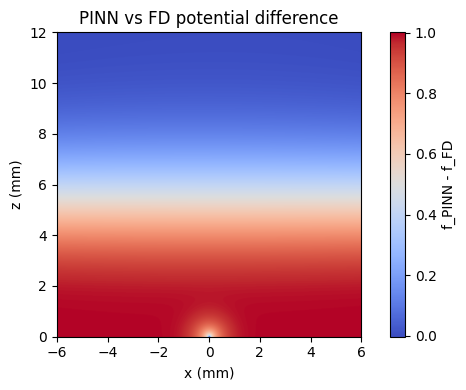

Boundary stats (PINN):
  electrode f mean=0.999, max|err|=5.587e-04
  gauge f mean=0.001, max|err|=7.103e-04


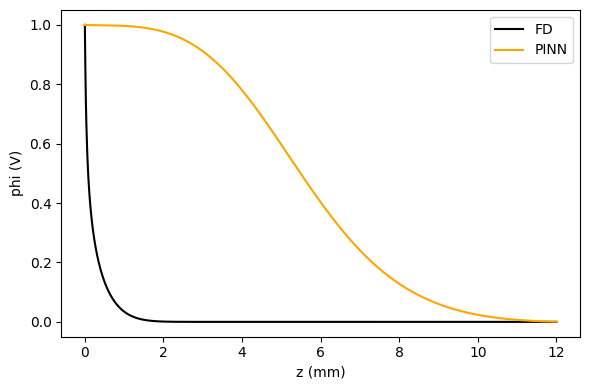

|?f| mean=3.24e-02, 95th%=6.74e-02


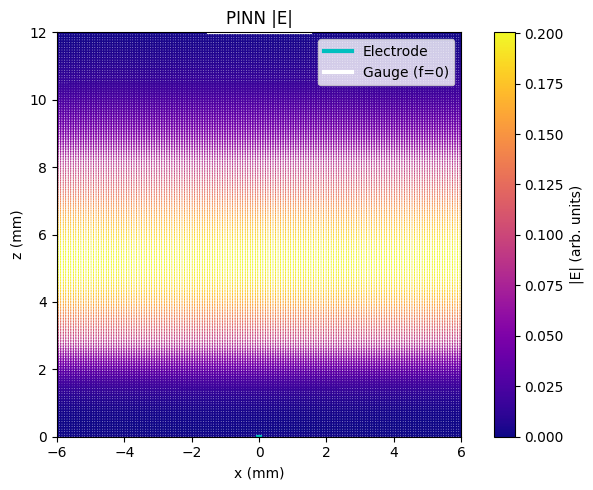

In [33]:
RUN_TRAINING = True

if RUN_TRAINING:
    print('Starting PINN training (Stage 1: coarse)...')
    run = train_tower_a_pinn()

    # --- Stage 2: refinement -----------------------------------------------
    print('Residual-adaptive refinement and fine-tuning (Stage 2)...')
    add_rar_points(run['problem'], run['solver'], n_new=20000, cand_factor=10)
    fine_tune_trainer(
        run['solver'],
        max_epochs=800,
        lr_factor=0.25,
        accelerator=trainer_device_kwargs()['accelerator'],
        devices=trainer_device_kwargs()['devices'],
        train_size=1.0, val_size=0.0, test_size=0.0, batch_size=None
    )
    # ------------------------------------------------------------------------

    print('Training complete. Evaluating on the FD grid...')
    phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(run['model'])
    compare_fd_to_pinn(phi_fd, phi_pinn)
    report_boundary_stats(phi_pinn, label='PINN')
    plt.figure(figsize=(6, 4))
    plot_centerline(phi_fd, label='FD', color='k')
    plot_centerline(phi_pinn, label='PINN', color='orange')
    plt.xlabel('z (mm)')
    plt.ylabel('phi (V)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    mean_res, p95_res = laplacian_stats(run['solver'], run['geometry'])
    print(f"|?f| mean={mean_res:.2e}, 95th%={p95_res:.2e}")
    vmax = float(np.quantile(Emag_pinn, 0.995))
    plot_field_map(Emag_pinn, Ex_pinn, Ez_pinn, title='PINN |E|', vmax=vmax)
else:
    print('Set RUN_TRAINING = True to launch the PINN demo.')


In [30]:
print('Samples per domain:')
for k, v in run['problem'].discretised_domains.items():
    print(f'  {k:>22s}: {len(v.tensor)}')


Samples per domain:
                interior: 44000
    interior_bottom_band: 32000
            electrode_bc: 6144
                gauge_bc: 6144
             bottom_left: 1024
            bottom_right: 1024
                top_left: 1024
               top_right: 1024
               left_wall: 1024
              right_wall: 1024
